In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups

from dnn import *

In [2]:
# Provide list of categories to consider
categories = ['alt.atheism',
              'comp.graphics', 
              'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware',  
              'comp.sys.mac.hardware',
              'comp.windows.x', 
              'misc.forsale', 
              'rec.autos', 
              'rec.motorcycles', 
              'rec.sport.baseball', 
              'rec.sport.hockey', 
              'sci.crypt', 
              'sci.electronics', 
              'sci.med', 
              'sci.space', 
              'soc.religion.christian', 
              'talk.politics.guns', 
              'talk.politics.mideast', 
              'talk.politics.misc', 
              'talk.religion.misc']

# Training subset
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
# Testing subset
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

print('Total samples in training data:', len(newsgroups_train.data))
print('Total samples in testing data:', len(newsgroups_test.data))

Total samples in training data: 11314
Total samples in testing data: 7532


In [3]:
# glove_dir = './glove.6B.50d.txt'  ## Replace the file name with your GloVe embedding file
# input_dim = 50   ## Choose the input dimension accordingly
glove_dir = './glove.6B.300d.txt'
input_dim = 300

vocab = {}
with open(glove_dir, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        vocab[word] = vector
f.close()

print('Found %s word vectors.' %len(vocab))

Found 400000 word vectors.


In [4]:
def get_embeddings(text):
    embedding = np.zeros(input_dim, dtype=float)
    i = 0
    for word in text.split(' '):
        if word in vocab:
            i += 1
            embedding += vocab[word]
    
    if i != 0:
        embedding /= i
        
    return embedding

In [5]:
def clean(text):
    """ Function to clean the text """
    text = text.lower()
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    
    # Remove numbers from string
    texter = re.sub(pattern=r"[+-]?\d+(?:\.\d+)?", repl="", string=texter, count=0, flags=0)
    texter = texter.replace("  ", " ")
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    texter = re.sub(r'[^\w\s]', '', texter)
    if texter == "":
        texter = ""
    return texter

In [6]:
dict_categories = {0: 0,
                   1: 1, 
                   2: 1,
                   3: 1,  
                   4: 1,
                   5: 1,
                   6: 2, 
                   7: 3, 
                   8: 3, 
                   9: 3, 
                   10: 3,
                   11: 4, 
                   12: 4, 
                   13: 4, 
                   14: 4,
                   15: 5, 
                   16: 6,
                   17: 6, 
                   18: 6, 
                   19: 6}

def transform(df):
    X = []
    y = []

    texts = df.data
    categories = df.target

    for text in texts:
        text = clean(text)

        X.append(get_embeddings(text))

    for category in categories:
        index_y = dict_categories[category]
        y.append(index_y)

    return np.array(X), np.array(y)

In [14]:
# Hyperparameters
num_epochs = 25
batch_size = 128
learning_rate = 0.001

num_layers = 1
num_nodes = 300
output_dim = 7
dropout = 0.25

# Model
dnn = DNN(input_dim, num_layers, num_nodes, output_dim, dropout)
print(dnn)

# Loss function
criterion = nn.CrossEntropyLoss()

# create your optimizer
optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)

DNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (hidden): ModuleList(
    (0): Linear(in_features=300, out_features=300, bias=True)
  )
  (fc2): Linear(in_features=300, out_features=7, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [10]:
X_train, y_train = transform(newsgroups_train)

## create iterator objects for train datasets
X_tr = torch.tensor(X_train, dtype=torch.float)
y_tr = torch.tensor(y_train, dtype=torch.long)
train = TensorDataset(X_tr, y_tr)
trainloader = DataLoader(train, batch_size=batch_size)

In [11]:
X_test, y_test = transform(newsgroups_test)

## create iterator objects for valid datasets
X_te = torch.tensor(X_test, dtype=torch.float)
y_te = torch.tensor(y_test, dtype=torch.long)
test = TensorDataset(X_te, y_te)
testloader = DataLoader(test)

In [15]:
training_loss = []
validation_loss = []
for epoch in range(num_epochs):
    dnn.train()
    for i, data in enumerate(trainloader):
        inputs, labels = data

        outputs = dnn(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(trainloader), loss.data))

    dnn.eval()
    
    # Compute and print loss.
    y_train_pred = dnn(X_tr)
    train_loss = criterion(y_train_pred, y_tr)
    y_test_pred = dnn(X_te)
    test_loss = criterion(y_test_pred, y_te)
    
    training_loss.append(train_loss.data)
    validation_loss.append(test_loss.data)
    

Epoch [1/25], Step [50/89], Loss: 1.0333
Epoch [2/25], Step [50/89], Loss: 0.7098
Epoch [3/25], Step [50/89], Loss: 0.5546
Epoch [4/25], Step [50/89], Loss: 0.5180
Epoch [5/25], Step [50/89], Loss: 0.4683
Epoch [6/25], Step [50/89], Loss: 0.4753
Epoch [7/25], Step [50/89], Loss: 0.4010
Epoch [8/25], Step [50/89], Loss: 0.3737
Epoch [9/25], Step [50/89], Loss: 0.3985
Epoch [10/25], Step [50/89], Loss: 0.3676
Epoch [11/25], Step [50/89], Loss: 0.3912
Epoch [12/25], Step [50/89], Loss: 0.3343
Epoch [13/25], Step [50/89], Loss: 0.3657
Epoch [14/25], Step [50/89], Loss: 0.3523
Epoch [15/25], Step [50/89], Loss: 0.3166
Epoch [16/25], Step [50/89], Loss: 0.3477
Epoch [17/25], Step [50/89], Loss: 0.3375
Epoch [18/25], Step [50/89], Loss: 0.2958
Epoch [19/25], Step [50/89], Loss: 0.2723
Epoch [20/25], Step [50/89], Loss: 0.2719
Epoch [21/25], Step [50/89], Loss: 0.2638
Epoch [22/25], Step [50/89], Loss: 0.2699
Epoch [23/25], Step [50/89], Loss: 0.2283
Epoch [24/25], Step [50/89], Loss: 0.2127
E

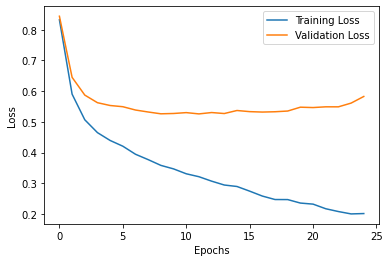

In [16]:
training_loss = np.array(training_loss)
validation_loss = np.array(validation_loss)

plt.plot(training_loss)
plt.plot(validation_loss)
plt.legend(["Training Loss", "Validation Loss"])

plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [18]:
# Final validation accuracy
total, correct = 0, 0
dnn.eval()
outputs = dnn(X_te)
_, predicted = torch.max(outputs, 1)

total += y_te.size(0)

correct += (predicted == y_te).sum()

print(f'Accuracy of the model is: {100*correct/total:.2f}%')

Accuracy of the model is: 81.89%
